# **Review Type Prediction via Deep Learning**

---



*DL and ANN exam session of 19/06/2025, Mucaj Deva 535333, exam project implementation*



---



In this implementation we will follow *step by step* what was written in the exam. We'll have:

1. Data loading and visualization
2. Data preprocessing (point 2a in the exam) and final input inspection (point 2b in the exam)
3. Training and Test sets split
4. Tokenization and Normalization (fit on training, transform on test)
5. Model configuration (correspoding to the 5th point in the exam, but including the loss -4th point-)
6. Model evaluation (6th and last point in the exam)



---



**Note**: *the model was trained for three epochs to ensure the notebook executes in a few minutes on a CPU. The total runtime typically falls between 10 and 15 minutes. If executed with more powerful hardware (e.g a GPU), we could increase the epoch count to achieve finer model tuning and results without extending training duration.*

## **1. Data Loading and Visualization**

In this section i will import the necessary libraries and visualize the dataset, the distribution and the type of the diferent coloumns, to make sure they match the description in the test.

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers, initializers, regularizers, optimizers

Loading the dataset:

We load the dataset using *pd.read_pickle()* from a GitHub repository.

In [ ]:
# Load the dataset from github repository
url = 'https://raw.githubusercontent.com/devs-glitch/Devs/main/input_data.pkl'
df = pd.read_pickle(url)

In [ ]:
df.head()

,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
88526,Scarsdale Scarsdale Place Kensington Kensingto...,5/2/2017,8.1,Copthorne Tara Hotel London Kensington,United Kingdom,7105,2,6.7,Expensive room rate that didn t include parki...,Bad_review
42019,53 53 59 Kilburn High Road Maida Vale London C...,8/4/2016,7.1,BEST WESTERN Maitrise Hotel Maida Vale,United Kingdom,1877,8,5.8,Bedroom in the basement No windows Very small...,Bad_review
80574,Pelai Pelai 28 Ciutat Vella 08002 Barcelona Spain,11/17/2016,8.6,Catalonia Ramblas 4 Sup,United Kingdom,4276,2,6.3,Room ready for a makeover Location,Bad_review
27131,3 3 Place du G n ral Koenig 17th arr 75017 Par...,2/4/2016,7.1,Hyatt Regency Paris Etoile,United Kingdom,3973,3,5.8,Firstly the lady at the check in desk was qui...,Bad_review
63857,Epping Epping Forest 30 Oak Hill London IG8 9N...,7/27/2016,7.5,Best Western PLUS Epping Forest,United Kingdom,587,7,3.3,Not being able to park my vehicle due to the ...,Bad_review


Now i inspect the review score distribution, and then the distribuition of the review types (we can indeed see that the review types, as specified in the test, are evenly distributed).

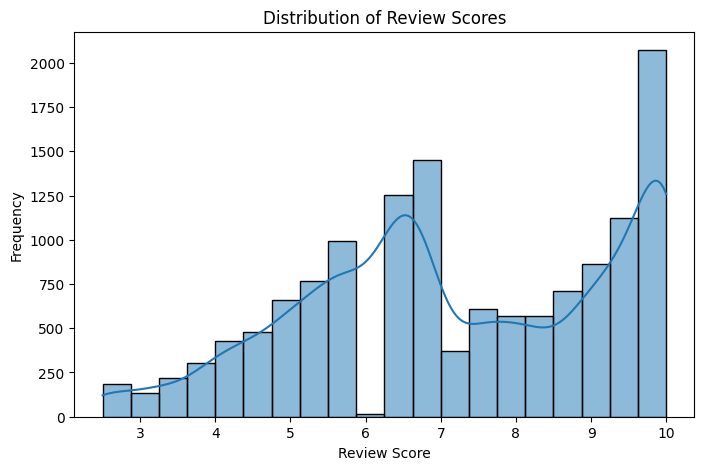

In [ ]:
# We visualize the distribution of Review_Score
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Score'], bins=20, kde=True)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

We can see that the review scores are overwhelmingly positive, with a lot of ratings at 9-10 , a smaller secondary peak around 6-7 , and very few scores below 4.


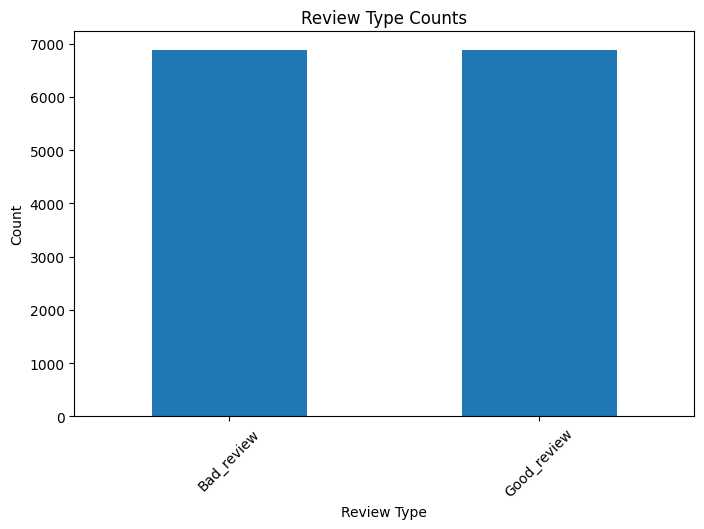

In [ ]:
# Visualize the review types
plt.figure(figsize=(8, 5))
df['Review_Type'].value_counts().plot(kind='bar')
plt.title('Review Type Counts')
plt.ylabel('Count')
plt.xlabel('Review Type')
plt.xticks(rotation=45)
plt.show()

The review types are indeed balanced.

Before proceeding with the data cleaning and transformation steps, we apply a stratified sampling to reduce our dataset to 50% of its original size while preserving the class distribution. This lets us dramatically speed up execution during development and testing without introducing label imbalances, since we want the notebook to run in a few minutes.

In [ ]:
label_col = 'Review_Type'
df = (
    df
    .groupby(label_col, group_keys=False) # We group the data by each label
    .sample(frac=0.5, random_state=42)
    .reset_index(drop=True)
)

Now we set a global seed for TensorFlow as a standart procedure. This affects the generation of random numbers in TensorFlow, which is crucial for initializing model weights and other random aspects of training.

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)



---




## **2. Input**

This is the second point of the exam, in which we do the pre-processing of the data and then see how the input that we will feed to the model presents itself.

### **a) Data Pre-Processing**

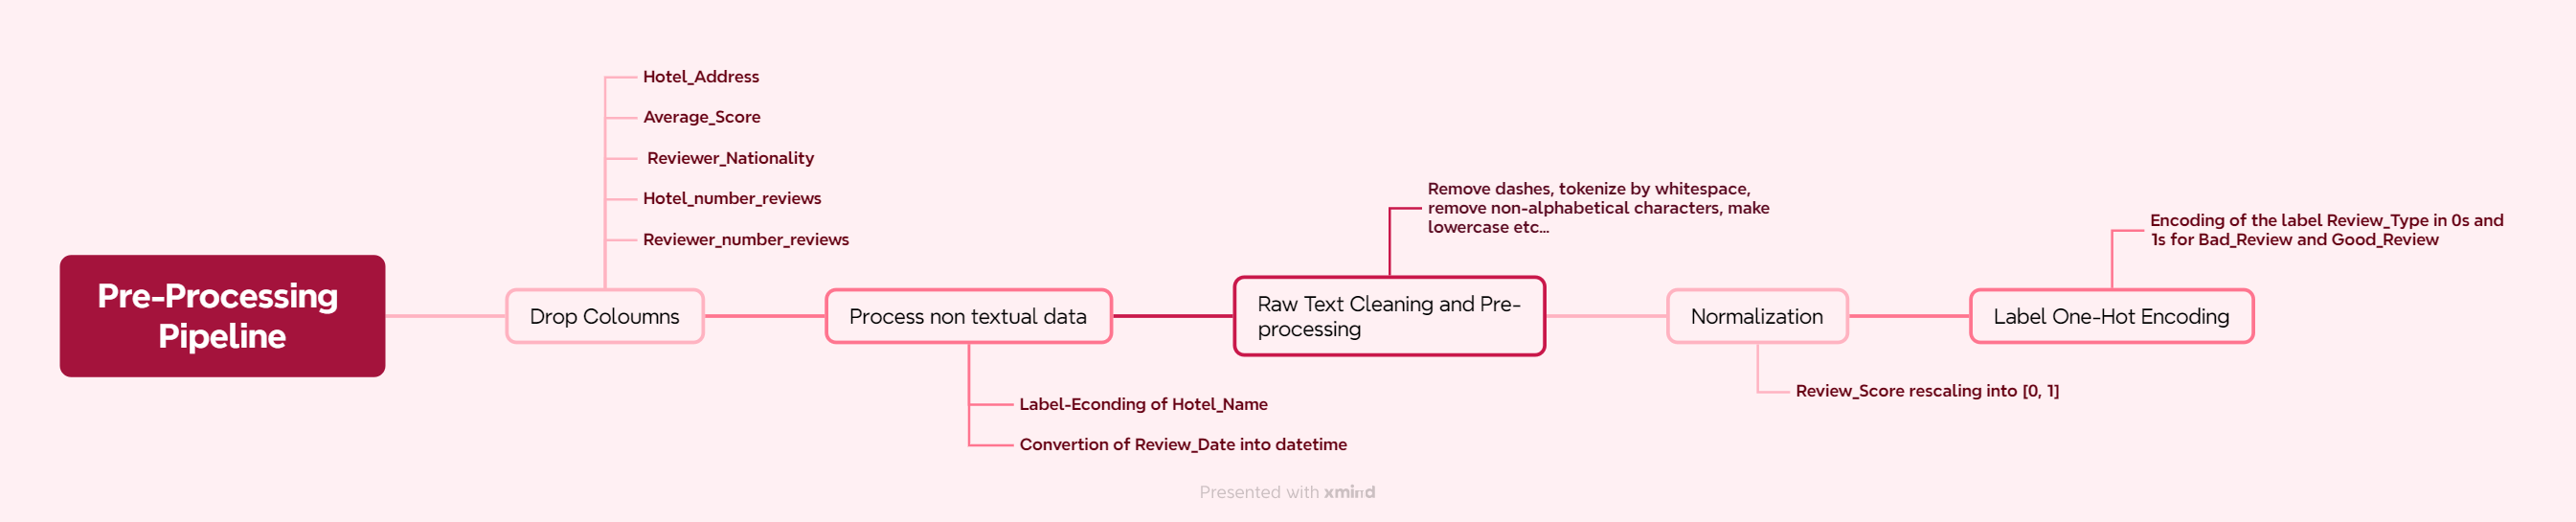

As said in the exam, we first drop the non-discriminative columns:
- *'Hotel_Address'*: redundant since we already have 'Hotel_Name'
- *'Hotel_number_reviews'*: non-discriminative to the scope of this task
- *'Reviwer_nationality'*: non-discriminative to the scope of this task
- *'Reviewer_number_reviews'*: non-discriminative to the scope of this task
- *'Average_Score'*: as advised by the professor

In [ ]:
df = df.drop(columns=['Hotel_Address', 'Hotel_number_reviews', 'Reviewer_Nationality',
                     'Reviewer_number_reviews', 'Average_Score'])

**CHANGE**

First, we perform pre-processing on the non-textual data. While I only explicitly mentioned the normalization of the review score in the exam for the pre-processing of the non-textual input data, it’s important to highlight that a more comprehensive pre-processing is required to effectively encode all non-textual features before feeding them into the dense layers of a multilayer perceptron. Specifically i will encode the *Hotel_Name* feature and transform *Review_Date* to datetime format.

The fully connected layers of the mlp, indeed, expect numerical vectors as input, so categorical features need to be transformed, while numerical features should be, as said, normalized or standardized. These transformations ensure that the data is compatible with the dense layers and improve the model’s learning efficiency, convergence stability, and overall performance.

In the exam, although I didn’t explicitly specify that the dense layers defined in the configuration were part of an mlp dedicated to processing the non-textual input, that was the intended design. The intention was to include the mlp as part of a combined architecture (through concatenation with the textual branch), and the use of the additional dense layers in the "layer configuration" part of the exam reflects this.

I hope that the lack of explicit mention didn't come off as a conceptual omission, but, still, i dind't specify it, so it's an actual change in the architecture.

First, since *Hotel_Name* is categorical, we convert it to numerical format using LabelEncoder. As said in the exam, these could be useful as some hotels may have consistenly better/worse reviews, and could be useful for the prediction.

In [ ]:
hotel_encoder = LabelEncoder()
df['hotel_encoded'] = hotel_encoder.fit_transform(df['Hotel_Name'])

Then we convert the *'Review_Date'* column from string to datetime format and extract useful temporal features. As said in the exam, this allows the model to potentially capture seasonal patterns or time-related trends in user behavior. We extract the year, month, and day components as separate numerical features for use in the model.

In [ ]:
# Convert Review_Date from string to datetime
df['Review_Date'] = pd.to_datetime(df['Review_Date'], errors='coerce') # The parameter errors='coerce' ensures that any invalid or unparseable dates are set to NaT (Not a Time)
df['review_year'] = df['Review_Date'].dt.year
df['review_month'] = df['Review_Date'].dt.month
df['review_day'] = df['Review_Date'].dt.day

Let's group together all the non-textual data into the array '*numeric_features*'

In [ ]:
numeric_features = df[['Review_Score', 'hotel_encoded', 'review_year', 'review_month', 'review_day']].values
print(numeric_features)

[[5.800e+00 2.120e+02 2.016e+03 8.000e+00 2.800e+01]
 [6.500e+00 4.280e+02 2.015e+03 1.200e+01 8.000e+00]
 [5.800e+00 1.088e+03 2.016e+03 7.000e+00 3.000e+00]
 ...
 [9.600e+00 1.078e+03 2.016e+03 1.200e+01 1.100e+01]
 [8.800e+00 1.800e+01 2.015e+03 1.000e+01 4.000e+00]
 [8.300e+00 1.208e+03 2.016e+03 1.000e+01 1.000e+00]]


In [ ]:
# Let's check how the dataset presents itself by now:
df.head()

,Review_Date,Hotel_Name,Review_Score,Review,Review_Type,hotel_encoded,review_year,review_month,review_day
0,2016-08-28,Corendon Vitality Hotel Amsterdam,5.8,Breakfast was same all days House keeping did...,Bad_review,212,2016,8,28
1,2015-12-08,Hilton London Angel Islington,6.5,Our room was very close to the lifts which we...,Bad_review,428,2015,12,8
2,2016-07-03,The Hoxton Holborn,5.8,Room was a shoebox Had to crawl over bed to m...,Bad_review,1088,2016,7,3
3,2017-01-16,Baglioni Hotel Carlton The Leading Hotels of t...,5.4,restaurant in hotel very expensive Staff in r...,Bad_review,88,2017,1,16
4,2016-04-21,Novotel London Excel,6.3,in room 501 next to a service door which I no...,Bad_review,865,2016,4,21


Here i define and apply, as said in point 2a of the exam, a text cleaning function called clean_text to the column 'Review'. The goal is to normalize and simplify raw review texts.

First as a standard procedure, we handle non-string inputs by returning an empty string. Then we replaces dashes (-) with spaces to preserve word separation. We removes all non-alphabetical characters using a precompiled regex pattern: r'[^a-zA-Z ]'.Then we convert the text to lowercase.

In [ ]:
# Precompile a regex pattern to remove everything except letters A–Z (upper/lowercase) and spaces
pattern = re.compile(r'[^a-zA-Z ]')

def clean_text(text):
    # handle non-string values
    if not isinstance(text, str):
        return ""
    # Replace dashes with spaces
    text = text.replace('-', ' ')
    # Remove all non-alphabetic characters
    text = pattern.sub('', text)
    # convert to lowercase
    return text.lower()

df['cleaned_review'] = df['Review'].apply(clean_text)


Let's check how the text data has been processed so far:

In [ ]:
df.head()

,Review_Date,Hotel_Name,Review_Score,Review,Review_Type,hotel_encoded,review_year,review_month,review_day,cleaned_review
0,2016-08-28,Corendon Vitality Hotel Amsterdam,5.8,Breakfast was same all days House keeping did...,Bad_review,212,2016,8,28,breakfast was same all days house keeping did...
1,2015-12-08,Hilton London Angel Islington,6.5,Our room was very close to the lifts which we...,Bad_review,428,2015,12,8,our room was very close to the lifts which we...
2,2016-07-03,The Hoxton Holborn,5.8,Room was a shoebox Had to crawl over bed to m...,Bad_review,1088,2016,7,3,room was a shoebox had to crawl over bed to m...
3,2017-01-16,Baglioni Hotel Carlton The Leading Hotels of t...,5.4,restaurant in hotel very expensive Staff in r...,Bad_review,88,2017,1,16,restaurant in hotel very expensive staff in r...
4,2016-04-21,Novotel London Excel,6.3,in room 501 next to a service door which I no...,Bad_review,865,2016,4,21,in room next to a service door which i notic...


Here i One-Hot encode the Review_Type coloumn into 0 and 1 (binary labels). We will use this as the label for our binary prediction. (As specified in the exam i will only use this to make my predictions, proceeding with a binary classification task).

In [ ]:
#  a lambda function that returns 1 if the review is a "Good_review", 0 otherwise
df['label'] = df['Review_Type'].apply(lambda x: 1 if x == 'Good_review' else 0)
labels = df['label'].values
print(labels)

[0 0 0 ... 1 1 1]


### **b) Final input of the model**

After the pre-processing step, we can see the final input's size, shape and type for our model.

In [ ]:
# Check numeric input ( 'numeric_features')
print("Numeric features:")
print("Shape:", numeric_features.shape)
print("Size:", numeric_features.size)
print("Data type:", numeric_features.dtype)

# Check textual input ('cleaned_review')
print("\nTextual features:")
print("Shape:", df['cleaned_review'].shape)
print("Size:", df['cleaned_review'].size)
print("Data type:", df['cleaned_review'].dtype)

# Check labels ('labels')
print("\nLabels:")
print("Shape:", labels.shape)
print("Size:", labels.size)
print("Data type:", labels.dtype)

Numeric features:
Shape: (6886, 5)
Size: 34430
Data type: float64

Textual features:
Shape: (6886,)
Size: 6886
Data type: object

Labels:
Shape: (6886,)
Size: 6886
Data type: int64




---



##**3. Splitting in traning and test sets**

After the preprocessing step we can proceed to split the dataset into training and testing sets. I didn't explicitly specified this in the exam, since it was taken for granted.

In [ ]:
# Split the numeric features, cleaned reviews, and labels into train/test sets (80/20 split)
X_num_train, X_num_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    numeric_features,
    df['cleaned_review'].values,
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels               # Preserve class distribution in both sets
)

**Duplicate reviews consideration**

*(just a verifcation + comment)*

I wanted to perform a series of sanity checks on the train/test split, given some post model evaluation considerations:
1. I want to verify that there is no row overlap between training and test sets (based on dataset index).
2. Then i check for duplicate reviews (so identical text) across the two sets.
3. We compare compares the class distribution (percentage of 0s and 1s) in train vs test (just to check).
4. We then compare summary statistics (mean) of key numeric features across the two sets.

In [ ]:
# verify that there are no overlapping indices, but since we didn’t split the original dataset, we don't have original indices.
# But we can simulate by comparing object identity

duplicate_indices = set(map(id, X_text_train)).intersection(map(id, X_text_test))
print("Duplicated rows between train and test (index):", len(duplicate_indices))  # should be 0

# check identical cleaned reviews in train and test sets
common_texts = set(X_text_train).intersection(X_text_test)
print("Identical reviews in train and test:", len(common_texts))
if common_texts:
    print("Examples of duplicates:", list(common_texts)[:5])

# Now we compare label proportions in train vs test --> shuold be roughly the same
train_pct = pd.Series(y_train).value_counts(normalize=True) * 100
test_pct  = pd.Series(y_test).value_counts(normalize=True) * 100
dist_df   = pd.DataFrame({'train_%': train_pct, 'test_%': test_pct})
print("\nClass distribution (%)\n", dist_df)

# we then compare means of each column
num_cols = ['Review_Score', 'hotel_encoded', 'review_year', 'review_month', 'review_day']
print("\nStatistiche sulle feature numeriche:")
for i, col in enumerate(num_cols):
    train_mean = X_num_train[:, i].mean()
    test_mean  = X_num_test[:, i].mean()
    print(f" {col:15s} → train mean={train_mean:.3f}, test mean={test_mean:.3f}")


Duplicated rows between train and test (index): 0
Identical reviews in train and test: 46
Examples of duplicates: [' everything nothing', ' location friendly staff', ' nothing', ' friendly staff', ' great breakfast']

Class distribution (%)
      train_%  test_%
0  50.018155    50.0
1  49.981845    50.0

Statistiche sulle feature numeriche:
 Review_Score    → train mean=7.244, test mean=7.236
 hotel_encoded   → train mean=619.549, test mean=609.033
 review_year     → train mean=2016.119, test mean=2016.118
 review_month    → train mean=6.546, test mean=6.710
 review_day      → train mean=15.607, test mean=15.518


In [ ]:
# Total number of reviews
print("Total reviews:", df.shape[0])

# Numeber of unique raw reviews
print("Unique raw reviews:", df['Review'].nunique())

# Number of unique reviews after 'clean_text'
print("Unique cleaned reviews:", df['cleaned_review'].nunique())


Total reviews: 6886
Unique raw reviews: 6617
Unique cleaned reviews: 6574


Given this results:

* Out of 6,886 reviews, 6,617 are unique, which means there are 269 exact duplicates - about 3.9% of the dataset.
* then , once we applied *clean_text*, unique reviews dropped to 6,574, so there are 312 cleaned duplicates in total - roughly 4.5%.
* --> The difference between the 312 cleaned duplicates and the 269 raw duplicates is 43, indicating that these reviews differed only in punctuation or special characters.

If we assume, as before, that 116 of these cleaned duplicate cases end up split between training and test sets, the leakage rate is approximately 1.7% (116 ÷ 6,886). What does this mean in practice?

1. Slightly inflated metrics
   If the model predicts those 116 leaked cases perfectly, it will artificially boost overall accuracy - but only by a few tenths of a percentage point.

2. Even if it's still a leakage, it's under 2%, and could be considered, by extreme, generally negligible: we might see a 0.2-0.3 point lift in reported accuracy.

Since i didn't predict this effect in the exam i will limit to make these considerations without trying to solve it by removing (for example) the duplicates on the cleaned text before the splitting (since it would also be a a change with respect to the performance, which we ignore in in this project).



---



##**4. Tokenization and Normalization**
In this step, we prepare the text and numeric inputs for the model:

1. Text Input (cleaned reviews):

  We first create a Keras tokenizer and “teaching” it our training reviews, including a special OOV marker for any words it hasn’t seen before.
Next, we use the internal *word-index* mapping it built from the training texts, so we can work with it independently, and tweak it so that every real word gets shifted up by one. Doing so, we free up the index 0 to mean “padding.” We essentially build a unque word vocabulary (as specified in point 2a of the exam). We also make sure our OOV tag still points where it should.
With our dictionary defined we can translate every review (both train and test) into a list of numbers, swapping in OOV whenever we hit an unknown.
We then figure out the longest review in the training set and pad all sequences to that same length by adding zeros at the end.
**CHANGE**
I choose to pick the 95th-percentile length (covering 95 % of reviews) as our cap: this trims only the longest 5 % of tokens, allowing to speed up training significantly (as said the notebook must run in a few minutes). Finally, we pad shorter sequences with zeros at the end and truncate longer ones at the end—guaranteeing every review is exactly the same length. *In the exam (point 2a) i dind't specify this truncation to the 95th-precentile, i will do it here only beacuse the notebook has to run in a short time*.

Finally, we print out a quick summary: how big our vocabulary is, a peek at the first few word-index pairs, and the shape of our padded training matrix.


2. Numeric Input (only *Review_Score*):

  We extract the Review_Score column (by index) from the numeric features array.
As specified in point 2a of the exam, i'm applying the scaling essentially only to this feature (even if all the numerical features could benefit from sclaing).Then, we scale it between 0 and 1 using MinMaxScaler fitting on trainig and applying the same transform on the test of course.

In [ ]:
# Create a tokenizer and reserve a token for out-of-vocabulary (OOV) words
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train) # fit on train

# build a unique word dictionary
word2idx = tokenizer.word_index.copy()

# reserve 0 for padding
word2idx = {w: i+1 for w, i in word2idx.items()}
word2idx["<OOV>"] = tokenizer.word_index[tokenizer.oov_token]

# convert text to sequences of integers (word indices)
X_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_test_seq  = tokenizer.texts_to_sequences(X_text_test)

# Compute the 95th-percentile length cap
lengths = [len(seq) for seq in X_train_seq]
seq_len = int(np.percentile(lengths, 95))
print(f"Fixed seq_len = {seq_len} tokens (95th percentile)")

# Pad/truncate train and test to that cap
X_train_padded = pad_sequences(
    X_train_seq,
    padding='post',
    truncating='post',
    maxlen=seq_len
)
X_test_padded = pad_sequences(
    X_test_seq,
    padding='post',
    truncating='post',
    maxlen=seq_len
)

print(f"Vocab size (incl. OOV): {len(word2idx)}")
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape: ", X_test_padded.shape)

Fixed seq_len = 100 tokens (95th percentile)
Vocab size (incl. OOV): 7302
X_train_padded shape: (5508, 100)
X_test_padded shape:  (1378, 100)


In [ ]:
# Review Score scaling

# we exract only 'Review_Score' by index ( index 0)
numeric_features_train = X_num_train[:, [0]]
numeric_features_test = X_num_test[:, [0]]

# Apply scaling
scaler = MinMaxScaler()
review_score_train_scaled = scaler.fit_transform(numeric_features_train)
review_score_test_scaled = scaler.transform(numeric_features_test)

**Comment**: we're scaling on the whole dataset instead of per fold (indeed, as said in the last point of the exam, we will perform a k-fold cross validation), which isn't perfect but is fine in this case. In deep learning, models are usually robust to small differences in feature scaling ( especially when the feature like *Review_Score* which has low variance and is already bounded). I think that the model tends to absorb such minor inconsistencies, so while per-fold scaling is technically better, the practical impact is negligible.

Now we combine the scaled review_score with the other numeric features (hotel_encoded, review_year, review_month, and review_day) into a single matrix ready for model input.


In [ ]:
# Select the other unnormalized numeric features (columns 1 to 4)
unnormalized_train = X_num_train[:, 1:]  # we take hotel_encoded, review_year, review_month, and review_day from the training set
unnormalized_test  = X_num_test[:, 1:]   # Same as before but for the test set

# Concatenate the scaled review_score with unnormalized features
numeric_train_full = np.concatenate([review_score_train_scaled, unnormalized_train], axis=1)
numeric_test_full  = np.concatenate([review_score_test_scaled, unnormalized_test], axis=1)


Before building and training the model, it's useful to check the shape of all input components: both text and numeric, as well as the labels.
We also print the tokenizer’s vocabulary size, which is needed when defining the Embedding layer.

In [ ]:
print(f"Tokenizer vocab size: {len(tokenizer.word_index) + 1}")  # +1 for OOV token
print(f"Train text shape: {X_train_padded.shape}")
print(f"Train numeric shape: {numeric_train_full}")
print(f"Train labels shape: {y_train.shape}")

Tokenizer vocab size: 7303
Train text shape: (5508, 100)
Train numeric shape: [[4.40000000e-01 5.00000000e+01 2.01500000e+03 8.00000000e+00
  7.00000000e+00]
 [5.60000000e-01 1.14900000e+03 2.01600000e+03 7.00000000e+00
  1.90000000e+01]
 [1.00000000e+00 8.20000000e+02 2.01600000e+03 1.20000000e+01
  2.00000000e+01]
 ...
 [8.40000000e-01 5.13000000e+02 2.01600000e+03 5.00000000e+00
  7.00000000e+00]
 [5.06666667e-01 1.04200000e+03 2.01600000e+03 8.00000000e+00
  2.70000000e+01]
 [8.40000000e-01 8.84000000e+02 2.01600000e+03 2.00000000e+00
  2.10000000e+01]]
Train labels shape: (5508,)


Let's visualise the split dataset now (we will limit to the first 5 samples).

In [ ]:
print("X_num_train")
print(X_num_train[:5])

print("\n X_num_test")
print(X_num_test[:5])

print("\n X_text_train")
print(X_text_train[:5])

print("\n X_text_test")
print(X_text_test[:5])

print("\n y_train")
print(y_train[:5])

print("\n y_test")
print(y_test[:5])

X_num_train
[[   5.8   50.  2015.     8.     7. ]
 [   6.7 1149.  2016.     7.    19. ]
 [  10.   820.  2016.    12.    20. ]
 [   8.3 1208.  2017.     6.    28. ]
 [  10.  1124.  2016.     3.    24. ]]

 X_num_test
[[   4.2  971.  2016.     3.    26. ]
 [   8.3  808.  2016.    10.    31. ]
 [   9.2 1211.  2016.    11.     4. ]
 [   6.7  875.  2016.     7.    18. ]
 [   4.2  522.  2016.     3.    15. ]]

 X_text_train
[' tried to have breakfast on deck at   am on a sunday morning was told i couldn t sit there because they had reservations at noon no concierge the entire  days we were there no help in acquiring tickets to any of the museums elevator was broken  room was kept very clean rooms were very quiet toilet looked like it was coming off wall and had trouble flushing at times '
 ' the receptionist was very rude and didn t offer to take our bags when we arrived early and wanted to travel around london for the day  value for money'
 ' nothing every thing' ' small rooms quietness'
 '



---



#**5. Model configuration**
####(Includes also points 3 and 4 of the exam: output layer configuration and loss function)

First we define the class of our model using TensorFlow Keras.
It processes two types of inputs:
- Text sequences (already tokenized and padded)
- The numerical features (normalized review scores, the hotel name, and the reviews' year, month and day)

The model architecture includes (as said in the exam in points 3 and 5):
- An Embedding + LSTM branch for text
- Dense connections for numeric input
- A merged path through multiple fully connected layers (already specified in the beginning as an actual change due to mis-specification)
- A final sigmoid output for binary classification

Parameters like LSTM units, dense layer sizes, dropout rate, and learning rate are configurable. As optimizer we will use Adam optimizer (as said in point 5b in the exam).

For the loss function, as specified in point 4 of the exam, we will use "binary cross entropy".

In [ ]:
class LSTMMLPModel(tf.keras.Model):
    def __init__(self,
                 vocab_size: int,
                 seq_len: int,
                 num_numeric_features: int,
                 emb_dim: int = 256,
                 lstm_units: list = [128, 64],
                 dense_units: list = [64, 32],
                 dropout_rate: float = 0.05,
                 learning_rate: float = 0.001):
        super().__init__()

        # Text branch
        self.embedding = layers.Embedding(vocab_size, emb_dim, name="embed") # embedding layer
        self.lstm1     = layers.LSTM(lstm_units[0], return_sequences=True, name="lstm1") # First LSTM layer
        self.drop1     = layers.Dropout(dropout_rate, name="drop_lstm1") # Dropout
        self.lstm2     = layers.LSTM(lstm_units[1], name="lstm2") # second LSTM layer

        # Numeric branch
        self.num_dense = layers.Dense(32, activation="relu", name="num_dense")

        # merge + MLP head
        self.concat = layers.Concatenate(name="concat") # We concatanate text and numeric representations along the feature axis
        self.mlp_layers = []
        for i, u in enumerate(dense_units):

            self.mlp_layers.append(layers.Dense(u, activation="relu", name=f"dense{i}")) # dense layers
            self.mlp_layers.append(layers.Dropout(dropout_rate, name=f"drop_dense{i}")) # dropout between dense blocks

        # sigmoid output layer
        self.out = layers.Dense(1, activation="sigmoid", name="output")

        # Optimizer (adam)
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)

    def call(self, inputs, training=False):
        text, num = inputs
        # text pipeliene = embed tokens + LSTM + dropout + LSTM
        x = self.embedding(text)
        x = self.lstm1(x, training=training)
        x = self.drop1(x, training=training)
        x = self.lstm2(x, training=training)

        # Numeric pipeline
        n = self.num_dense(num, training=training)

        # Merge
        x = self.concat([x, n])

        # Pass trough the MLP layers
        for layer in self.mlp_layers:
            x = layer(x, training=training)

        return self.out(x) # final probability

    def compile(self, **kwargs):
        # we sue the stored optimizer
        super().compile(optimizer=self.optimizer,
                        loss="binary_crossentropy",
                        metrics=["accuracy"],
                        **kwargs)

    def update_hyperparams(self, dropout_rate=None, learning_rate=None):
        if dropout_rate is not None:
            # Update dropout rates
            for layer in self.layers:
                if isinstance(layer, layers.Dropout):
                    layer.rate = dropout_rate
        if learning_rate is not None:
            # update the optimizer learning rate
            tf.keras.backend.set_value(self.optimizer.learning_rate, learning_rate)


**Here is a simplified sketch of our model:**

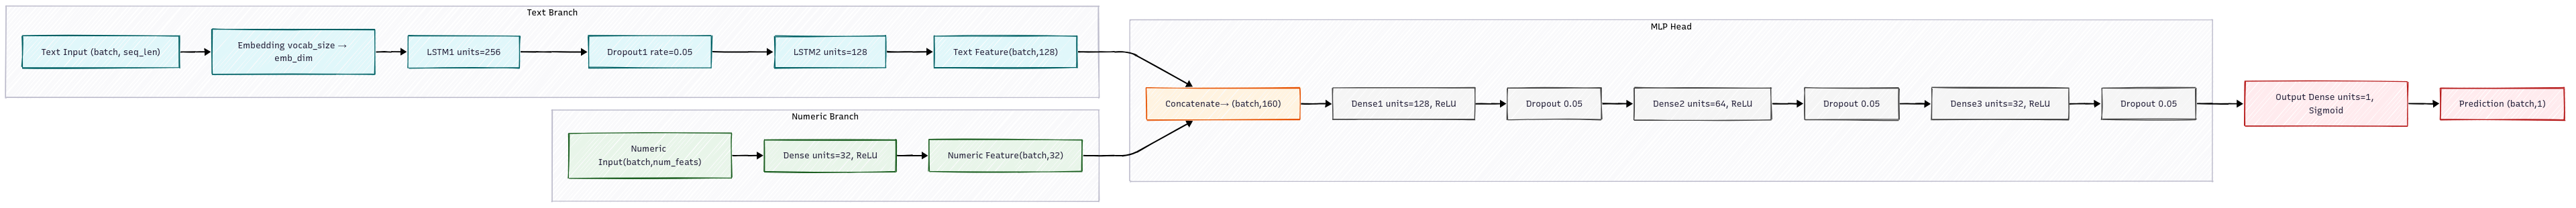

Before we can train the LSTM-MLP model, we need to tell it the exact shape of our inputs and kick off its weight initialization. First, we pull the sequence length (number of tokens per review) and the count of extra numeric predictors from our padded and concatenated arrays. With those dimensions, we instantiate LSTMMLPModel, a subclassed model passing in vocabulary size, sequence length, number of numeric features, and our chosen hyperparameters (embedding size, LSTM layers, dense layer widths, dropout, and learning rate). We do a single dummy forward pass with zero-filled inputs to build all weight variables.

In [ ]:
# compute the input dimensions
seq_len   = X_train_padded.shape[1]
num_feats = numeric_train_full.shape[1]

# We instantiate the subclassed model
model = LSTMMLPModel(
    vocab_size=len(tokenizer.word_index) + 1,
    seq_len=seq_len,
    num_numeric_features=num_feats,
    emb_dim=256,
    lstm_units=[256, 128],
    dense_units=[128, 64, 32],
    dropout_rate=0.05,
    learning_rate=0.001
)

# Now compile it (we're not building the weights yet)
model.compile()

# Dummy forward pass to build the weights
_ = model(
    (tf.zeros((1, seq_len), dtype=tf.int32),
     tf.zeros((1, num_feats), dtype=tf.float32))
)

# Show real shapes and parameter counts
model.summary()

Model: "lstmmlp_model_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embed (Embedding)               │ (1, 100, 256)          │     1,869,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (LSTM)                    │ (1, 100, 256)          │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_lstm1 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (1, 128)               │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ num_dense (Dense)               │ (1, 32)                │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concat (Concatenate)            │ (1, 160)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense0 (Dense)                  │ (1, 128)               │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense0 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense1 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (1, 32)                │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense2 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (1, 1)                 │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,623,169 (10.01 MB)

 Trainable params: 2,623,169 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

We will now perform 3-fold stratified cross-validation using the LSTM + MLP model. As said in the last point of the exam, we will indeed use kfold cross validation.

First we define number of folds, training epochs, and batch size.

Loop over each fold:
* We split the data into training and validation sets (preserving label distribution) for both text (padded sequences) and numeric features.
* Instantiate a fresh LSTMMLPModel with the same architecture and hyperparameters.
* Compile to set up optimizer (Adam) and loss (BCE).
* Fit on the current fold’s training data, validating on its hold-out set.
* Evaluate final accuracy on the validation set and record it.

Then we aggregate results across folds to report the mean ± standard deviation of validation accuracy.

In [ ]:
# Cross validation hyperparameters
NUM_FOLDS  = 3  # 3-fold cross validation
EPOCHS     = 3  # 3 epochs for each fold
BATCH_SIZE = 64

# we prepare the stratifiedkfold splitter
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
cvscores, fold_histories = [], []

# define the loop over each fold
for fold, (train_idx, val_idx) in enumerate(
        kf.split(X_train_padded, y_train), start=1):
    print(f"\n--- Fold {fold}/{NUM_FOLDS} ---")

    # Slice out this fold’s train/val data

    # text sequences
    X_text_tr = X_train_padded[train_idx]
    X_text_va = X_train_padded[val_idx]

    #numeric features
    X_num_tr  = numeric_train_full[train_idx]
    X_num_va  = numeric_train_full[val_idx]

    # labels
    y_tr      = y_train[train_idx]
    y_va      = y_train[val_idx]

    # We instantiate and compile a fresh model for this fold
    fold_model = LSTMMLPModel(
        vocab_size=len(word2idx) + 1,  # size of embedding input
        seq_len=seq_len,               # Fixed sequence length
        num_numeric_features=X_num_tr.shape[1],
        emb_dim=256,
        lstm_units=[256, 128],
        dense_units=[128, 64, 32],
        dropout_rate=0.05,
        learning_rate=0.001
    )
    fold_model.compile()  # This sets up optimizer and  loss

    # Then we train on the fold’s training split, and validate on its hold-out split
    history = fold_model.fit(
        x=(X_text_tr, X_num_tr),
        y=y_tr,
        validation_data=((X_text_va, X_num_va), y_va),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
    )
    fold_histories.append(history)

    # Evaluate the performance
    loss, acc = fold_model.evaluate(
        x=(X_text_va, X_num_va),
        y=y_va,
        verbose=0
    )
    print(f"Fold {fold} — val_acc: {acc:.4f}")
    cvscores.append(acc)


# Then we want to see the cross-validated accuracy
print(f"\nAverage CV Accuracy: {np.mean(cvscores):.4f} ± {np.std(cvscores):.4f}")


--- Fold 1/3 ---
Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4950 - loss: 12.5941 - val_accuracy: 0.4967 - val_loss: 1.2446
Epoch 2/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5015 - loss: 2.7813 - val_accuracy: 0.5240 - val_loss: 0.7055
Epoch 3/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5061 - loss: 1.1853 - val_accuracy: 0.4853 - val_loss: 0.7012
Fold 1 — val_acc: 0.4853

--- Fold 2/3 ---
Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 61s 968ms/step - accuracy: 0.5035 - loss: 19.0526 - val_accuracy: 0.4815 - val_loss: 0.7530
Epoch 2/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 58s 995ms/step - accuracy: 0.5061 - loss: 1.3644 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 3/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4958 - loss: 0.8786 - val_accuracy: 0.5000 - val_loss: 0.6927
Fold 2 — val_acc: 0.5000

--- Fold 3/3 ---
Epoch 1/3
58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5087 - loss: 8.9487 - val_accuracy: 0.4940 - val_loss: 0.7752
Epoch 2/3
58/

**Comment on kfold cross validation results**:

These cross-validation results are consistent but disappointing with respect to the model performance and stability across folds:

Overall Accuracy (~49.5 %).

The mean validation accuracy is essentially at chance (0.4951 ± 0.0069). With a binary classification task, we’d expect a well-tuned model to exceed 0.50 by a comfortable margin. Here, we’re barely breaking even, indicating the model isn’t learning a reliable signal from the combined text + numeric inputs.

If we inspect fold by fold:

* Fold 1 starts at ~49.7 % on epoch 1, peaks briefly at 52.4 % (epoch 2), but then dips to 48.5 %.
* Fold 2 moves from ~48.2 % up to a flat 50.0 % by epoch 3.
* Fold 3 jumps to 49.4 %, touches 51.6 % mid-training, but ends at 50.0 %.

Each fold exhibits only minor fluctuations around 0.50, with no clear upward trend as training continues. That plateau suggests the architecture isn't capturing enough meaningful patterns.

Loss behavior

The validation loss hovers around 0.70-0.78 across folds, which is what we normally expect for a binary cross-entropy when predictions are no better than random. The training loss does drop each epoch, but it doesn’t translate into improved validation performance, which i think might be hinting at either subtle overfitting early on, or that the model is simply “memorizing” noise rather than generalizing.



---



#**6. Model Evaluation**

Before evaluating our model’s final performance, we rebuild it one last time with the hyperparameters we selected (embedding dimension, LSTM and dense layer sizes, dropout rate, and learning rate) and compile it to configure the optimizer and loss function. We then train this fresh model on the entire training set, using a relatively small batch size for more stable gradient updates. Once training completes, we generate probability predictions on our untouched test set and apply a 0.5 threshold to convert them into binary class labels.

As said in the last point of the exam ,to understand where our model succeeds and where not, we compute the confusion matrix, revealing true positives, false positives, true negatives, and false negatives. Finally, we visualize the confusion matrix with a heatmap.

But first, I want to do a sanity check. I start by asking the model to give me a probability for each test sample (using both the padded text and numeric inputs) so I end up with a number between 0 and 1 for each review. Then I double-check that I haven’t messed up anywhere by printing the shapes of *y_test* and *y_test_probs*, making sure every probability really is in the 0-1 range, and confirming my true labels are only 0s and 1s. Once I know everything lines up, I turn those probabilities into 0/1 decisions with a simple “if it’s at least 0.5, call it 1; o/w call it 0.” I count how many 0s and 1s I predicted and compare that to the actual counts to catch any weird bias (like predicting only one class).

In [ ]:
# predict probabilities from the inner Keras model
y_test_probs = final_model.predict(
    (X_test_padded, numeric_test_full),
    batch_size=32
).flatten()

# quick sanity checks
print("y_test shape:", y_test.shape)
print("y_test_probs shape:", y_test_probs.shape)
print(f"  Prob range: min={y_test_probs.min():.3f}, max={y_test_probs.max():.3f}")
print(f"  Unique true labels: {np.unique(y_test)}")

# this is the 0/1 conversion
y_test_pred = np.where(y_test_probs >= 0.5, 1, 0)

# Show the counts
print("Predicted label counts:", np.bincount(y_test_pred))
print("True     label counts:", np.bincount(y_test.astype(int)))

# Then we print a classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step
y_test shape: (1378,)
y_test_probs shape: (1378,)
  Prob range: min=0.040, max=0.955
  Unique true labels: [0 1]
Predicted label counts: [667 711]
True     label counts: [689 689]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57       689
           1       0.57      0.59      0.58       689

    accuracy                           0.57      1378
   macro avg       0.57      0.57      0.57      1378
weighted avg       0.57      0.57      0.57      1378



In [ ]:
# build and compile the model
final_model = LSTMMLPModel(
    vocab_size=len(word2idx) + 1,
    seq_len=seq_len,
    num_numeric_features=numeric_train_full.shape[1],
    emb_dim=256,
    lstm_units=[256, 128],
    dense_units=[128, 64, 32],
    dropout_rate=0.05,
    learning_rate=0.001
)
final_model.compile()  # uses binary_crossentropy + Adam internally

# Train on entire training set
history = final_model.fit(
    x=(X_train_padded, numeric_train_full),
    y=y_train,
    epochs=3,
    batch_size=32,
    verbose=1
)

# Predict probabilities on the test set
y_probs = final_model.predict((X_test_padded, numeric_test_full)).flatten()

# convert to 0/1 labels at 0.5
y_pred = (y_probs >= 0.5).astype(int)

# print a classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Epoch 1/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 115s 612ms/step - accuracy: 0.4996 - loss: 14.4396
Epoch 2/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 143s 614ms/step - accuracy: 0.5185 - loss: 1.0691
Epoch 3/3
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 611ms/step - accuracy: 0.4921 - loss: 0.8546
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.40      0.45       689
           1       0.51      0.62      0.56       689

    accuracy                           0.51      1378
   macro avg       0.51      0.51      0.51      1378
weighted avg       0.51      0.51      0.51      1378



Confusion Matrix:
 [[384 305]
 [283 406]]


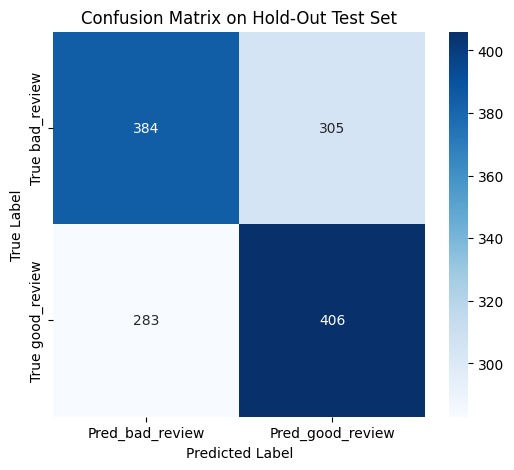

In [ ]:
# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred_bad_review", "Pred_good_review"],
    yticklabels=["True bad_review", "True good_review"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Hold-Out Test Set")
plt.show()

This confusion matrix shows that out of 689 true negatives, the model correctly predicts 384 and mislabels 305 as positive, while of 689 true positives it correctly recovers 406 and misses 283.

In practice, the model is almost equally likely to confuse a “bad” review for a “good” one (305 false positives) as it is to overlook a truly “good” review (283 false negatives).

While this performance exceeds a naive 50 % baseline, the large off-diagonal values (over 40 % error rate per class) indicate there’s substantial room to sharpen discrimination, for example the need of more effectice reguralization techniques.

In the last point of the exam, i said i would have exploited the presision-recall curve for the model evaluation., to see how well our classifier balances precision against recall at various decision thresholds.

First we first compute the underlying data points for the precision-recall curve. Using precision_recall_curve, we obtain precision and recall values across every possible probability cutoff, and then summarize the entire curve into a single scalar: the average precision (AP). Finally, we draw the curve annotated with the AP score.

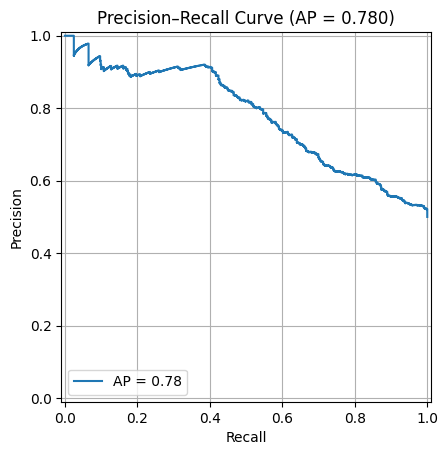

In [ ]:
# calculate presition, recall, and treshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# we calculate the average presision (summarizes the precision–recall trade off across all thresholds)
avg_prec = average_precision_score(y_test, y_pred_probs)

# visualize the curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_prec)
disp.plot()
plt.title(f'Precision–Recall Curve (AP = {avg_prec:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


This precision-recall curve (with an AP of 0.78) tells us about the model’s behavior across decision thresholds.

* At low recall (below ~ 0.2), precision hovers very near 1.0, meaning the top-scoring predictions are almost all true positives.
* As we pull in more examples (increasing recall toward 0.4), precision only decreases to around 0.9, indicating the model is still very confident in that mid-range.
* Beyond a recall of ~ 0.4, precision begins a more pronounced, steady descent, settling around 0.6 once we push recall above 0.8.

An AP of 0.78 is a strong signal that, overall, the classifier ranks positive examples well: on average, precision remains high as we cover more of the true positives. Practically, this curve shows the model is well-calibrated for ranking good reviews: it can reliably identify the most clear-cut positives and still perform respectably when pushed for full coverage.

###**Model Evaluation Considerations**



Reflecting on the results of this two-branch LSTM + MLP model, I recognize that its core architecture is fundamentally sound and suited to multimodal data. However, when I look at its test-set performance around 51 percent accuracy, I can assess that the model isn’t yet capturing enough of the underlying signal to outperform a simple baseline by a comfortable margin. That suggests that although the design is appropriate, the current training regimen and representational capacity are not leveraged in a proper way.

I could introduce techniques such as L2 weight decay on the dense layers, which can help prevent co-adaptation of neurons (so when multiple neurons in a layer become overly reliant on each other), and/or batch normalization on the merged representations, which may stabilize training and improve generalization. On the architectural front, replacing the unidirectional LSTMs with a bidirectional variant would allow the text branch to consider context from both past and future tokens, which often translates into richer  embeddings and better classification.

To optimize performance efficiently, i would also replace the manual hyperparameter trials with a systematic grid search over key settings (like the learning rate, the hidden unit size, the dropout rate, and so on...) so we could identify the best combination reliably.


I’d also revisit the feature engineering around the date: rather than feeding also the days values, which can inject noise, I wouls encode seasonal cycles, keeping only the years and the months.
